#Image Analysis and Processing
#2nd set of Exercises
* Paranou Dimitra 7115152100034
* Gavrielatos Marios 7115152100023

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import imutils
from scipy import ndimage
from statistics import mean

MatLab imreconstruct in OpenCV Python for Morphological Reconstruction:
https://gist.github.com/navidsad/589ec8ad0f66a199bff4db401c8f7baa

Performs morphological opening on the mask image, using the marker image to identify high-intensity objects in the mask.

In [ ]:
def imreconstruct(marker, mask, radius = 1, iterations = 10):
  
    """Iteratively expand the markers white keeping them limited by the mask during each iteration.
    :param marker: Grayscale image where initial seed is white on black background.
    :param mask: Grayscale mask where the valid area is white on black background.
    :param radius Can be increased to improve expansion speed while causing decreased isolation from nearby areas.
    :returns A copy of the last expansion.
    """

    i = 1
    kernel = np.ones(shape=(radius * 2 + 1, radius * 2 + 1), dtype=np.uint8)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)
        if i >= iterations:
            return expanded

        # Termination criterion: Expansion didn't change the image at all
        if (marker == expanded).all():
            return expanded
        marker = expanded
        i += 1


# Exercise 1

1) Find the main edges in image11.jpg.

Steps:
1. Convert to gray scale
2. Apply gaussian blur
3. Detect edges using Canny
4. Find lines
5. Color differenly every line

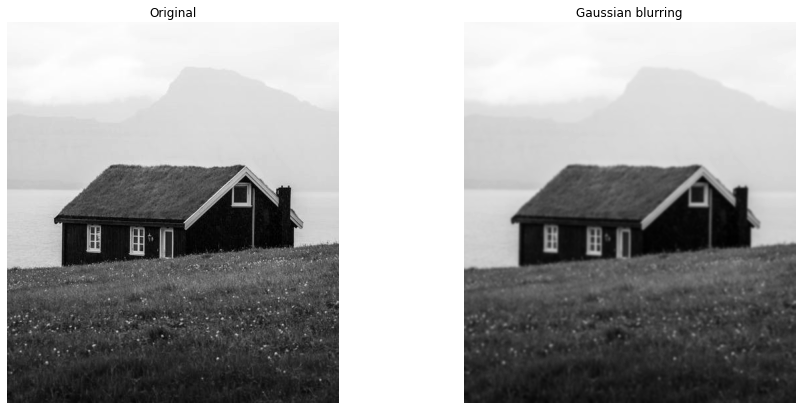

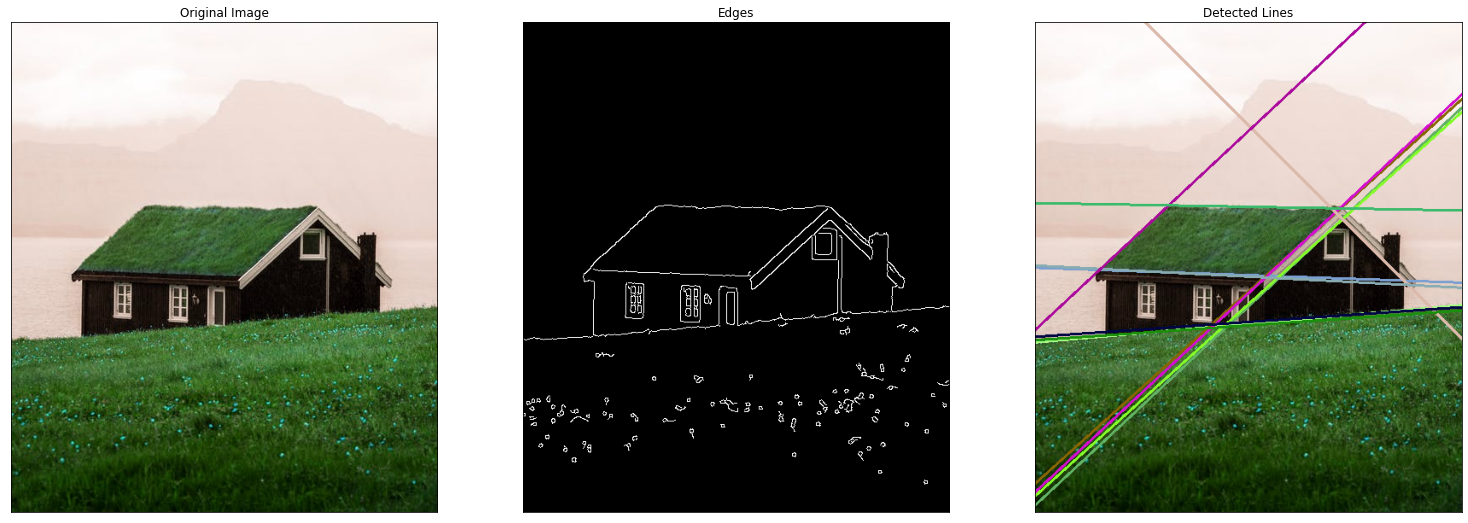

In [ ]:
img = cv2.imread('image11.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

fig, axes=plt.subplots(1,2, figsize=(15,7))

plt.subplot(121), plt.imshow(gray, cmap='gray'), plt.title('Original'), plt.axis('off')
blur=cv2.GaussianBlur(gray,(7,7), 0)
plt.subplot(122), plt.imshow(blur, cmap='gray'), plt.title('Gaussian blurring'), plt.axis('off')
plt.show()

#With Gaussian blur
edges = cv2.Canny(blur,50,150,apertureSize = 3)

fig, axes = plt.subplots(1, 3, figsize=(26,14))

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(edges, cmap = 'gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])

lines = cv2.HoughLines(edges,1,np.pi/180,80)

for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = [r,g,b]

        cv2.line(img,(x1,y1),(x2,y2),rgb,thickness=2)

plt.subplot(133),plt.imshow(img)
plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])

#Detected main edges 
plt.show()

2) Estimate the angle (with respect to the horizontal axis) of the diagonal edges of the roof.

Steps:
1. Convert to gray scale
2. Detect edges using Canny
3. Find lines
4. Apply restriction on theta (θ is the angle formed by the perpendicular line and the horizontal axis)

The angles (with respect to the horizontal axis) of the diagonal edges of the roof are the following:
47.0
48.0
48.0
47.0
135.0
47.0


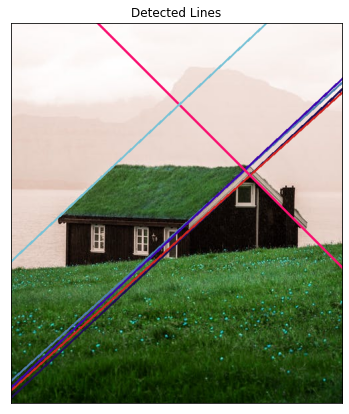

In [ ]:
img = cv2.imread('image11.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#With Gaussian blur
edges = cv2.Canny(blur,50,150,apertureSize = 3)

fig, axes = plt.subplots(1, 1, figsize=(14,7))

#With Gaussian blur
lines = cv2.HoughLines(edges,1,np.pi/180,80)
print("The angles (with respect to the horizontal axis) of the diagonal edges of the roof are the following:")
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = [r,g,b]
        
        if (0.4<= theta <= 1.3) or (theta > 1.7):
            print(round(math.degrees(theta), 3,))
            cv2.line(img,(x1,y1),(x2,y2),rgb,thickness=2)

plt.subplot(111),plt.imshow(img)
plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])

plt.show()

3) Find the corners in the image11.jpg.

Steps:

1. Turn image to grayscale
2. Apply median blur (kernel size=7)
3. Apply erosion (kernel size=7x7)
4. Harrys corner detection
5. goodFeaturesToTrack corner detection

Steps 2-3 are applied in order to reduce the noise in the image.

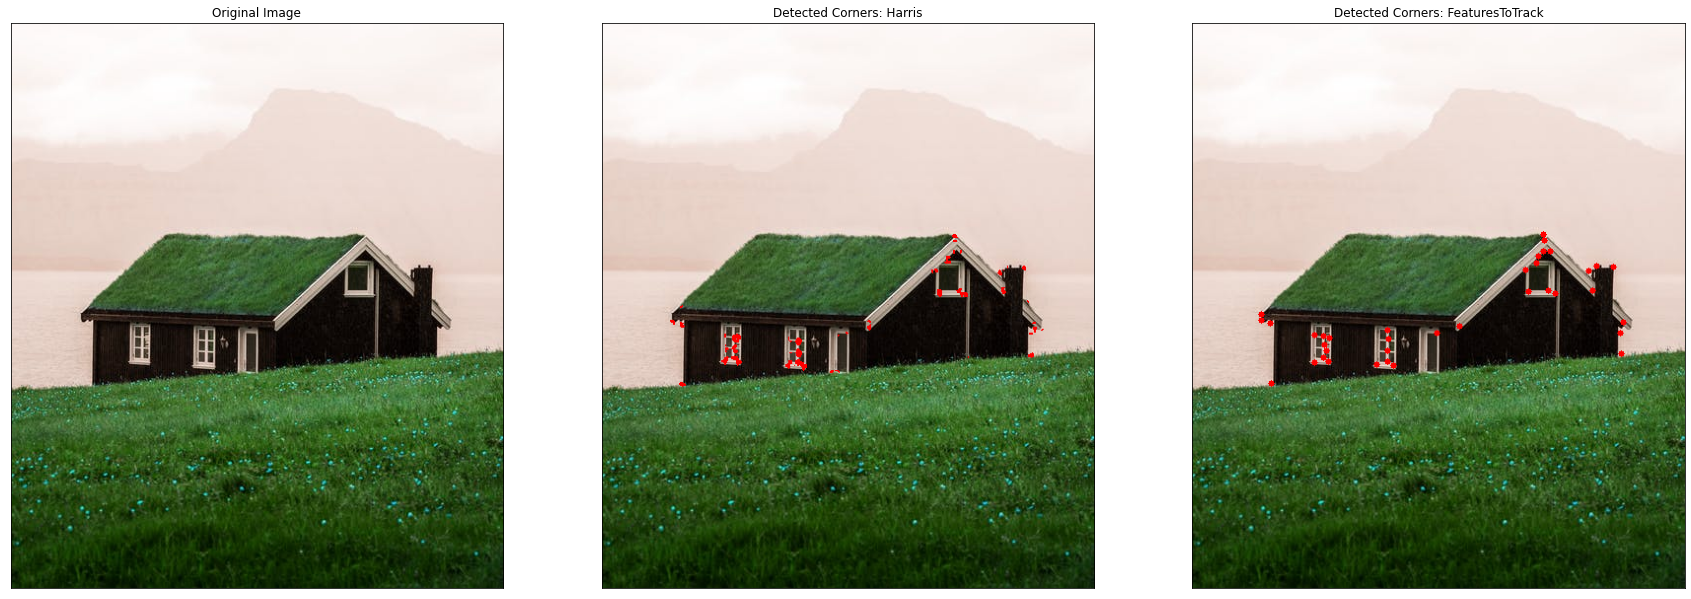

In [ ]:
img = cv2.imread('image11.jpg')
img_3 = np.copy(img)
img_3_b = np.copy(img)
gray = cv2.cvtColor(img_3,cv2.COLOR_BGR2GRAY)
blur=cv2.medianBlur(gray,7)

kernel = np.ones((4,4), np.uint8)

img_erosion = cv2.erode(blur, kernel, iterations=1)

# corners detection
dst = cv2.cornerHarris(img_erosion,4,3,0.04)

fig, axes = plt.subplots(1, 3, figsize=(30,17))

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

# Threshold for an optimal value, it may vary depending on the image.
img_3[dst>0.01*dst.max()]=[255,0,0]

plt.subplot(132),plt.imshow(img_3)
plt.title('Detected Corners: Harris'), plt.xticks([]), plt.yticks([])

# detect corners with the goodFeaturesToTrack function.
corners = cv2.goodFeaturesToTrack(img_erosion,37,0.01,6)
corners = np.int0(corners)

# we iterate through each corner, 
# making a circle at each point that we think is a corner.
for i in corners:
    x,y = i.ravel()
    cv2.circle(img_3_b,(x,y),3,255,-1)

plt.subplot(133),plt.imshow(img_3_b)
plt.title('Detected Corners: FeaturesToTrack'), plt.xticks([]), plt.yticks([])

plt.show()

4) Based on the detected corners, locate the windows.

Step 1: Isolate detected areas

In [ ]:
corners = img_3.copy()
corners = np.zeros(dst.shape).astype(np.float32)
corners[dst>0.01*dst.max()]=1

Step 2:
* Find edges
* Apply reconcstruction
* Apply dilation (kernel size = 2x2)
* Fill holes
* Apply opening (kernel size = 13x13)

In [ ]:
edges = cv2.Canny(blur,50,100,apertureSize = 3)
rec = imreconstruct(corners.astype(np.uint8), edges, 5)

kernel = np.ones((2,2), np.uint8)
rec = cv2.dilate(rec,kernel,iterations = 1)
rec = ndimage.binary_fill_holes(rec).astype(np.uint8)


kernel = np.ones((13,13),np.uint8)
rec = cv2.morphologyEx(rec, cv2.MORPH_OPEN, kernel)

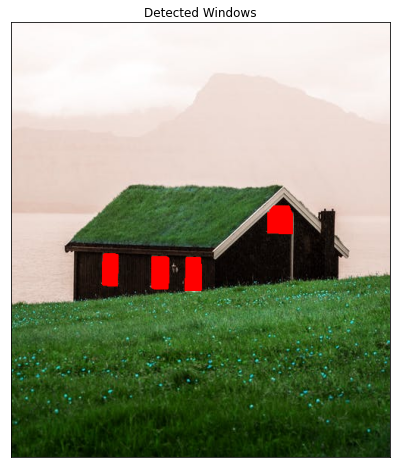

In [ ]:
rec = abs(rec/np.max(rec)-1)
image_4 = np.copy(img)
for index1, row in enumerate(rec):
    for index2, col in enumerate(row):
        if col == 0:
            image_4[index1][index2][0] = 255
            image_4[index1][index2][1] = 0
            image_4[index1][index2][2] = 0

plt.figure(figsize=(8,8)), plt.imshow(image_4)
plt.title('Detected Windows'), plt.xticks([]), plt.yticks([])
plt.show()

# Exercise 2

1) Estimate the angle (with respect to the horizontal axis) of the billiard cue in
image31.jpg. To verify your answer, rotate the input image accordingly. The
result should be like image32.jpg.

Steps:


1. Covert image to gray scale
2. Apply Gaussian Blur
3. Find the edges
4. Find the cue line
5. Rotate image based on cue line angle



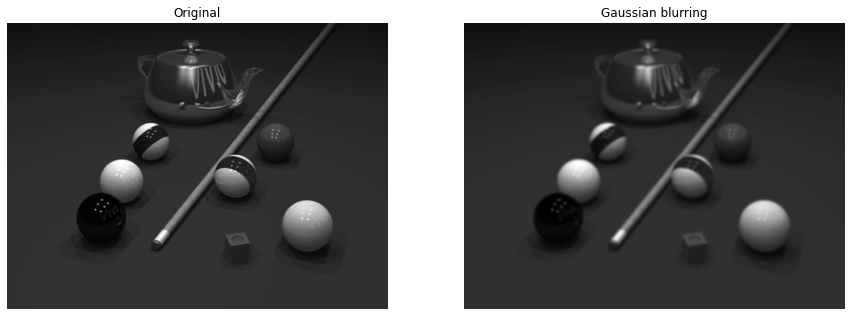

Average angle: 39.00000108527387


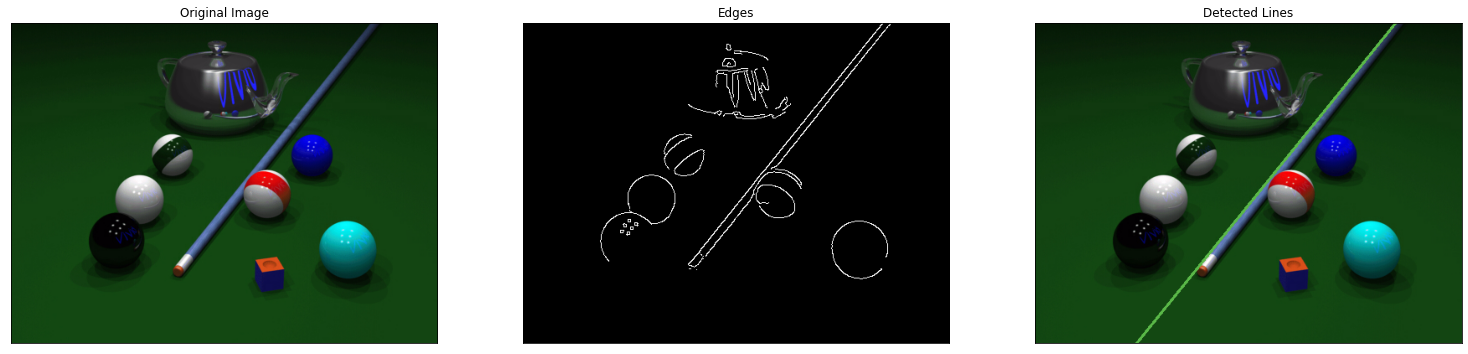

In [ ]:
img = cv2.imread('image31.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

fig, axes=plt.subplots(1,2, figsize=(15,7))

plt.subplot(121), plt.imshow(gray, cmap='gray'), plt.title('Original'), plt.axis('off')
# Apply Gaussian Blur
blur = cv2.GaussianBlur(gray,(7,7), 0)
plt.subplot(122), plt.imshow(blur, cmap='gray'), plt.title('Gaussian blurring'), plt.axis('off')
plt.show()

# FInd the edges of the image
edges = cv2.Canny(blur,50,150,apertureSize = 3)

fig, axes = plt.subplots(1, 3, figsize=(26,14))

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(edges, cmap = 'gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])

# Find the line of the cue
lines = cv2.HoughLines(edges,1,np.pi/180,170)

sum_theta = 0
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = [r,g,b]

        sum_theta += math.degrees(theta)
        cv2.line(img,(x1,y1),(x2,y2),rgb,thickness=2)

# define the angle that is going to be rotated
angle = sum_theta/len(lines)
print("Average angle:",angle)
plt.subplot(133),plt.imshow(img)
plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])

plt.show()

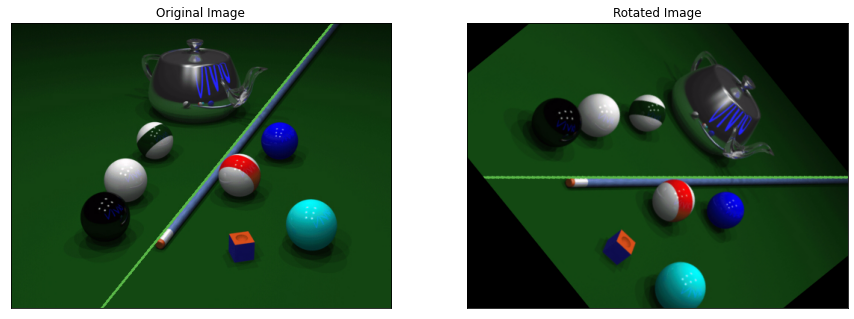

In [ ]:
fig, axes=plt.subplots(1,2, figsize=(15,7))
# rotate the image based on the angle
rotated_image = imutils.rotate(img, angle=angle-90)

plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(rotated_image)
plt.title('Rotated Image'), plt.xticks([]), plt.yticks([])
plt.show()

2) Combine image31.jpg and image32.jpg to generate an image like image33.jpg.

Steps:


1. Convert image to gray scale
2. Find the edges
3. Detect the cue line
4. Rotate the image based on the cue
5. Detect the billard balls
6. Convert to binary image
7. Detect connected componets
8. Detect the cue
9. Calculate ratio -> 1/10
10. Plot only the cue



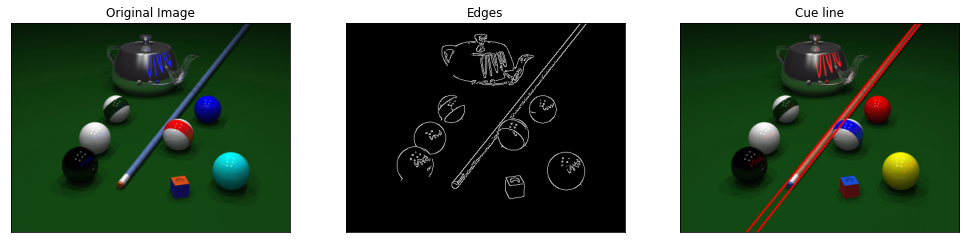

In [ ]:
img1 = cv2.imread('image31.png')
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# find the edges
edges = cv2.Canny(gray,100, 200)

# get the line of the cue
lines = cv2.HoughLines(edges,1,np.pi/180,200)
thetas_list = []
for line in lines:
    for rho,theta in line:
        thetas_list.append(theta)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(gray,(x1,y1),(x2,y2),(255,0,0),2)

fig, axes=plt.subplots(1,3, figsize=(17,10))

plt.subplot(131),plt.imshow(img1)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(edges, cmap = 'gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(gray, cmap = 'gray')
plt.title('Cue line'), plt.xticks([]), plt.yticks([])

plt.show()

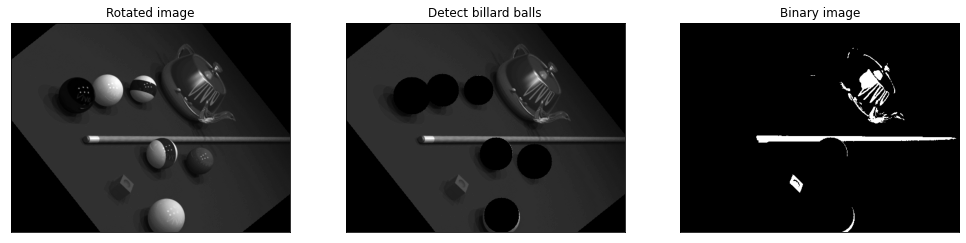

In [ ]:
img1 = cv2.imread('image31.png', 0)

fig, axes=plt.subplots(1,3, figsize=(17,10))

# rotate the image based on the cue
thetas_mean = mean(thetas_list)
degrees = thetas_mean*(180/math.pi)

img1 = ndimage.rotate(img1, -(90-degrees), reshape=False)

plt.subplot(131),plt.imshow(img1, cmap="gray")
plt.title('Rotated image'), plt.xticks([]), plt.yticks([])

img1_rot = np.copy(img1)

# find the balls
circles = cv2.HoughCircles(img1, cv2.HOUGH_GRADIENT, 1, 20, param1 = 30, param2 = 30, minRadius = 25, maxRadius = 33)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img1, (x, y), r+2, (0), -1)

plt.subplot(132),plt.imshow(img1, cmap="gray")
plt.title('Detected billard balls'), plt.xticks([]), plt.yticks([])

# get the binary image
img_bin = cv2.threshold(img1, 60, 255, cv2.THRESH_BINARY)[1]
plt.subplot(133),plt.imshow(img_bin, cmap="gray")
plt.title('Binary image'), plt.xticks([]), plt.yticks([])

plt.show()

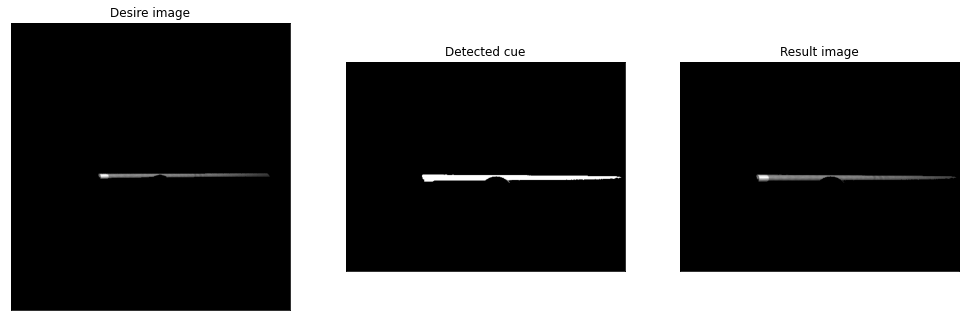

In [ ]:
# detect the connected components of the binary image
num_labels, labels = cv2.connectedComponents(img_bin)

# get the shapes
shapes = {}
for i in range (labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i][j] != 0:
            cur_num = int(labels[i][j])
            if cur_num not in shapes.keys():
                shapes[cur_num] = {0:[i],1:[j]}
            else:
                if i not in shapes[cur_num][0]:
                    shapes[cur_num][0].append(i)
                if j not in shapes[cur_num][1]:
                    shapes[cur_num][1].append(j)

for key in shapes.keys():
    len_1 = len(shapes[key][0])
    len_2 = len(shapes[key][1])
    shapes[key] = [len_1, len_2]

# detect the billard cue label / ratio
proportion_threshold = 0.1 
for key in shapes:
    proportion_1 = shapes[key][0]/shapes[key][1]
    proportion_2 = shapes[key][1]/shapes[key][0]
    if proportion_1 <= proportion_threshold:
        bil_cue_label = key
    elif proportion_2 <= proportion_threshold:
        bil_cue_label = key

# keep the billard cue in the photo -> assign 1's in the cue and 0's around it 
img_bil_cue = np.zeros([labels.shape[0],labels.shape[1]])
for i in range (labels.shape[0]):
    for j in range(labels.shape[1]):
        if int(labels[i][j]) != bil_cue_label:
            img_bil_cue[i][j] = 0
            img1_rot[i][j] = 0
        else:
            img_bil_cue[i][j] = 1

fig, axes=plt.subplots(1,3, figsize=(17,10))

plt.subplot(131),plt.imshow(cv2.imread('image33.png', 0), cmap="gray")
plt.title('Desired image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(img_bil_cue, cmap="gray")
plt.title('Detected cue'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(img1_rot, cmap="gray")
plt.title('Result image'), plt.xticks([]), plt.yticks([])

plt.show()